In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


We have three main data files at our disposal:

- `train_essays.csv`: The training set with essays written by students and a few examples of LLM-generated essays.
- `test_essays.csv`: The test set with essays for which we need to predict whether they were generated by an LLM.
- `train_prompts.csv`: The prompts used to generate the essays, containing both the instructions and source texts.

Our first step is to load these files and get an intuitive feel for their content.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_essays_path = '/kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
train_prompts_path = '/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv'

train = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
train.rename(columns = {'essay_id': 'id',
                        'label' : 'generated',
                        'prompt': 'prompt_id'}, inplace=True)


train['prompt_id'] = pd.factorize(train['prompt_id'])[0]

train = train[['id', 'prompt_id', 'text', 'generated']]

df = pd.read_csv(train_essays_path)

train_prompts_df = pd.read_csv(train_prompts_path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
df = pd.concat([train, df])

## Exploratory Data Analysis (EDA)

In [ ]:
missing_values_train = df.isnull().sum()
print("missing_values_train:\n", missing_values_train)
missing_values_prompts = train_prompts_df.isnull().sum()
print("\nmissing_values_prompts:\n", missing_values_prompts)

missing_values_train:
 id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_prompts:
 prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


In [ ]:
import re

numeral_pattern = re.compile(r'\b\d+\b')  # Matches any whole number
word_number_pattern = re.compile(
    r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', re.IGNORECASE)  # Matches number words from one to ten

def feature_eng(df):
    df['text'] = df['text'].str.split()  # Split the 'text' column into words
    df['text'] = df['text'].str.join(' ')  # Join the split words back into a space-separated string

    words = df['text'].str.split()
    sentences = df['text'].str.split('.')

    df['word_count'] = words.apply(len)
    df['unique_word_count'] = words.apply(lambda x: len(set(x)))
    df['sentence_count'] = sentences.apply(len)
    df['avg_word_length'] = words.apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
    df['essay_length'] = df['text'].apply(len)
    df['numeral_matches'] = df['text'].str.count(numeral_pattern.pattern)
    df['word_number_matches'] = df['text'].str.count(word_number_pattern.pattern)

    return df


In [ ]:
print('The shape of the dataset before feature_eng is ',df.shape)

df = feature_eng(df)

print('The shape of the dataset after feature_eng is ',df.shape)


The shape of the dataset before feature_eng is  (45584, 4)
The shape of the dataset after feature_eng is  (45584, 11)


In [ ]:
# Group by 'generated' to compare these metrics between student-written and LLM-generated essays
# comparison_metrics = df.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length', 'essay_length', 'numeral_matches', 'word_number_matches']].mean()
# comparison_metrics


## EDA - Text Length Analysis

Next, we'll explore the length of the essays, as this might be an indicative feature of whether an essay was generated by a student or an LLM.

We will calculate the length of each essay and compare the distributions between the two categories.

In [ ]:

# Plot the distribution of essay lengths
# plt.figure(figsize=(12, 6))
# sns.histplot(df['essay_length'], bins=50, kde=True)
# plt.title('Distribution of Essay Lengths')
# plt.xlabel('Essay Length')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 8))
# sns.boxplot(x='generated', y='essay_length', data=df)
# plt.title('Comparison of Essay Lengths by Source')
# plt.xlabel('Essay Source')
# plt.ylabel('Essay Length')
# plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
# plt.show()


Essay length varies widely for students and is typically longer than the few LLM-generated essays available.

## EDA - Common words

In [ ]:
# from collections import Counter
# import itertools

# def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
#     all_text = ' '.join(text_series).lower()
#     words = all_text.split()
#     word_freq = Counter(words)
#     common_words = word_freq.most_common(num_words)

#     # Plot the most common words
#     plt.figure(figsize=(15, 6))
#     sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.xlabel('Words')
#     plt.ylabel('Frequency')
#     plt.show()

# plot_most_common_words(df[df['generated'] == 0]['text'], title="Most Common Words in Student Essays")
# plot_most_common_words(df[df['generated'] == 1]['text'], title="Most Common Words in LLM-generated Essays")

Common words in student essays differ from those in LLM-generated texts, suggesting potential linguistic patterns for classification.

# Creating the model

In [ ]:
from sklearn.model_selection import train_test_split


# X should contain your feature columns, and y should contain your target variable
X = df.drop(columns=['generated', 'id'])
y = df['generated']


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model

num = X[['prompt_id', 'word_count', 'unique_word_count', 'sentence_count', 'avg_word_length', 'essay_length', 'numeral_matches', 'word_number_matches']]


# Text data preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X['text'])
text_sequences = tokenizer.texts_to_sequences(X['text'])
X = pad_sequences(text_sequences,maxlen=2000)
X = np.concatenate((X, num),axis = 1)

# Split the data into training and validation sets (adjust the test_size as needed)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Force TensorFlow to use GPU if available
if tf.test.is_gpu_available():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)



# DNN model architecture (customize as needed)
input_layer = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 9, output_dim=32)(input_layer)

conv1d_1 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
conv1d_1 = BatchNormalization()(conv1d_1)
conv1d_1 = Dropout(0.2)(conv1d_1)
maxpooling_1 = GlobalMaxPooling1D()(conv1d_1)

flatten_layer = Flatten()(embedding_layer)
hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flatten_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.2)(hidden_layer)

# Concatenate the results from Conv1D and Dense layers
concatenated = Concatenate()([maxpooling_1, hidden_layer])

output_layer = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2008)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2008, 32)     2730592     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 2004, 128)    20608       ['embedding[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 64256)        0           ['embedding[0][0]']              
                                                                                              

In [ ]:

# Training the model

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=512)

Epoch 1/5
72/72 [==============================] - 29s 270ms/step - loss: 1.0069 - accuracy: 0.9232 - val_loss: 1.0500 - val_accuracy: 0.7502
Epoch 2/5
72/72 [==============================] - 18s 250ms/step - loss: 0.4083 - accuracy: 0.9907 - val_loss: 0.7525 - val_accuracy: 0.8924
Epoch 3/5
72/72 [==============================] - 17s 242ms/step - loss: 0.2724 - accuracy: 0.9956 - val_loss: 0.6011 - val_accuracy: 0.8022
Epoch 4/5
72/72 [==============================] - 17s 239ms/step - loss: 0.2009 - accuracy: 0.9973 - val_loss: 0.4661 - val_accuracy: 0.9715
Epoch 5/5
72/72 [==============================] - 16s 218ms/step - loss: 0.1563 - accuracy: 0.9974 - val_loss: 0.4105 - val_accuracy: 0.9778


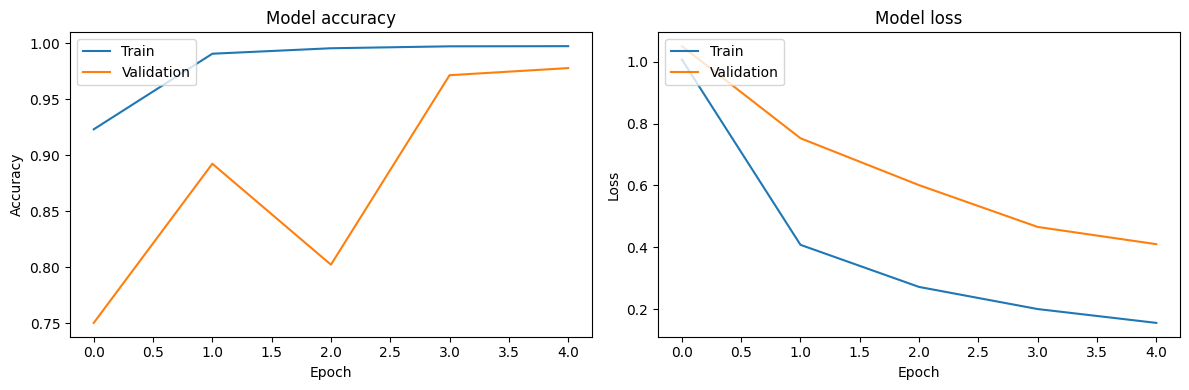

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


#### Create a dummy summission file

In [ ]:
test_df = pd.read_csv(f'/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')  # Read CSV file into a DataFrame


In [ ]:
X_test = test_df.drop(columns=['id'])
X_test = feature_eng(X_test)
num = X_test[['prompt_id', 'word_count', 'unique_word_count', 'sentence_count', 'avg_word_length', 'essay_length', 'numeral_matches', 'word_number_matches']]

text_sequences = tokenizer.texts_to_sequences(X_test['text'])
X_test= pad_sequences(text_sequences, maxlen=2000)

X_test = np.concatenate((X_test ,num),axis = 1)





In [ ]:
# Initialize an array to store predictions for each fold
fold_preds = np.zeros(shape=(len(test_df),), dtype='float32')

y = model.predict(X_test)

fold_preds += y.squeeze()

1/1 [==============================] - 0s 157ms/step


In [ ]:
sub_df = test_df[["id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["generated"] = fold_preds.squeeze()

sub_df.to_csv('submission.csv',index=False)

In [ ]:
# Display the first 2 rows of the submission DataFrame
sub_df.head()

,id,generated
0,0000aaaa,0.847895
1,1111bbbb,0.842863
2,2222cccc,0.835007
